<a ><img src="https://media.fox5atlanta.com/media.fox5atlanta.com/photo/2017/01/29/Delta3_1485740598814_2667919_ver1.0_640_360.jpg" ></a>
* Hi guys, I hope you are doing fine. 
* In this kernel, we use data for **LAX passenger traffic**.
* We are going to analyze the data, visualize our data to understand it better.  
* After that, we will focus on **time series prediction** to predict the number of passengers for future dates.
* For time series prediction, we will use **SARIMA** method. 
 
 <br> <font color='blue'> Content: 
    * [Loading data](#1)
    * [Univariate analysis](#3)
    * [Bivariate analysis](#4)
    * [Data preparation](#5)
    * [Model selection](#6)
    * [Model fit and prediction](#7)
    * [Parameter tuning](#8)
    * [Year ahead forecast](#9)
    * [Summary](#10)


<a id="1"></a> <br>
## Loading Data

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

The first several rows of the data are presented below.

In [2]:
file = pd.read_csv("../input/los-angeles-international-airport-passenger-traffic-by-terminal.csv")
file2 = file.copy()
file2.head()

,DataExtractDate,ReportPeriod,Terminal,Arrival_Departure,Domestic_International,Passenger_Count
0,2014-05-01T00:00:00.000,2006-01-01T00:00:00.000,Imperial Terminal,Arrival,Domestic,490
1,2014-05-01T00:00:00.000,2006-01-01T00:00:00.000,Imperial Terminal,Departure,Domestic,498
2,2014-05-01T00:00:00.000,2006-01-01T00:00:00.000,Misc. Terminal,Arrival,Domestic,753
3,2014-05-01T00:00:00.000,2006-01-01T00:00:00.000,Misc. Terminal,Departure,Domestic,688
4,2014-05-01T00:00:00.000,2006-01-01T00:00:00.000,Terminal 1,Arrival,Domestic,401535


The data we have loaded contains records for the following features:
 * DataExtractDate	
 * ReportPeriod	
 * Terminal	
 * Arrival_Departure	
 * Domestic_International	
 * Passenger_Count

In [3]:
print("Number of null values: \n")
print(file2.isnull().sum())

Number of null values: 

DataExtractDate           0
ReportPeriod              0
Terminal                  0
Arrival_Departure         0
Domestic_International    0
Passenger_Count           0
dtype: int64


<a id="3"></a> <br>
## Univariate Analysis

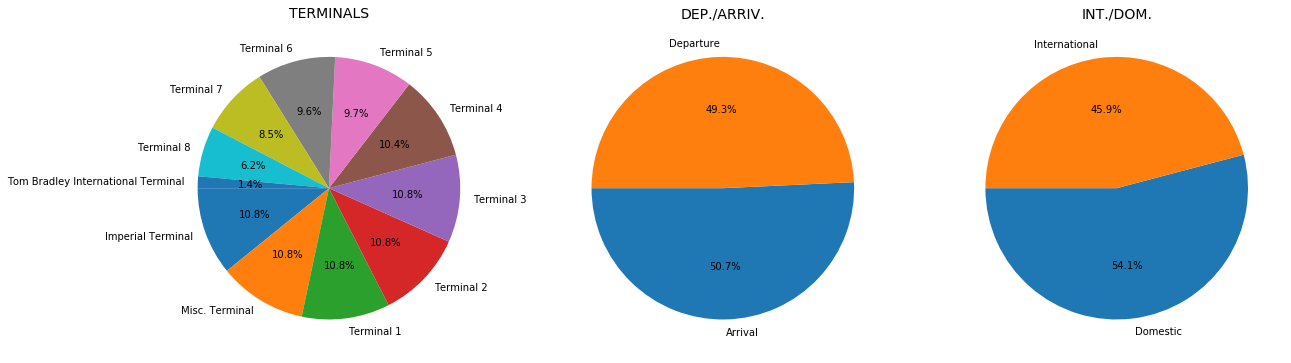

In [4]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3, figsize=(20,10))
ax1.pie(file2['Terminal'].value_counts(), labels=file2.Terminal.unique(), autopct='%1.1f%%', startangle=180)
ax2.pie(file2['Arrival_Departure'].value_counts(), labels=file2.Arrival_Departure.unique(), autopct='%1.1f%%', startangle=180)
ax3.pie(file2['Domestic_International'].value_counts(), labels=file2.Domestic_International.unique(), autopct='%1.1f%%', startangle=180)
ax1.set_title("TERMINALS", fontsize=14), ax2.set_title("DEP./ARRIV.", fontsize=14), ax3.set_title("INT./DOM.", fontsize=14)
plt.draw()

<a id="4"></a> <br>
## Bivariate analysis

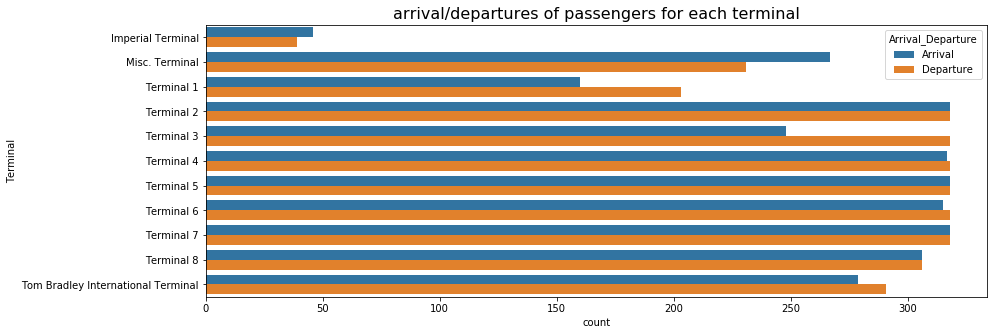

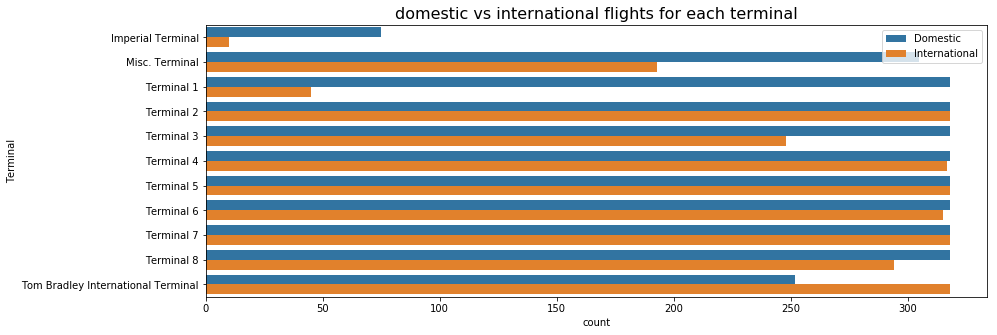

In [5]:
plt.figure(figsize=(14,5))
sns.countplot(y="Terminal", hue="Arrival_Departure", data=file2)
plt.title("arrival/departures of passengers for each terminal", fontsize=16)
plt.show()
plt.figure(figsize=(14,5))
sns.countplot(y="Terminal", hue="Domestic_International", data=file2)
plt.title("domestic vs international flights for each terminal", fontsize=16)
plt.legend(loc="best")
plt.show()

<a id="5"></a> <br>
## Data preparation

As we are going to focus on **time series prediction** to predict the number of passengers, we'll keep only the column "Passenger_Count". It will show the number of passengers recorded in the mentioned report period.

Let's group our data by Report period and aggregate the sum of the number of passengers for the mentioned periods.

In [6]:
file2.groupby("ReportPeriod").sum().head()

,Passenger_Count
ReportPeriod,
2006-01-01T00:00:00.000,4756159
2006-02-01T00:00:00.000,4250155
2006-03-01T00:00:00.000,5090294
2006-04-01T00:00:00.000,5087874
2006-05-01T00:00:00.000,5177408


Now we'll convert the column of time to a more confortable format. We'll rename our columns as "Date" and "Number".

In [7]:
x=file2.groupby("ReportPeriod").sum()
file3=pd.DataFrame(x,columns=["Passenger_Count"])

file3.index=pd.to_datetime(file3.index, format='%Y-%m-%d').strftime('%Y-%m')
file3.index.name ="Date"
file3.columns=["Number"]
file3.head()

,Number
Date,
2006-01,4756159
2006-02,4250155
2006-03,5090294
2006-04,5087874
2006-05,5177408


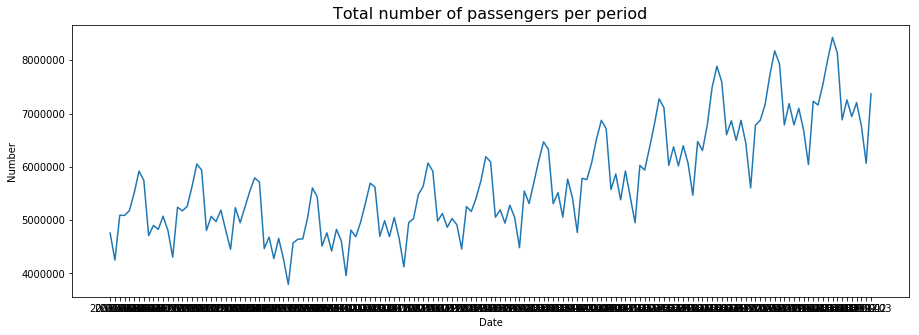

In [8]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(file3)
ax.set(xlabel="Date", ylabel="Number")
ax.set_title("Total number of passengers per period", fontsize=16)
plt.show()

In [9]:
#Changing the order of the indices
df=pd.DataFrame(file3)
df_ascending=df.sort_index(axis=0, ascending=True, inplace=False)
df=df_ascending

From inspecting the plot we can conclude that this time series has a mostly positive linear trend, multiplicative seasonal patterns, and possibly some irregular patterns. This information suggests to use a SARIMA model to do our forecasting. First we split 80% of data for training and 20% fo testing.

After splitting data into training and testing sets we get:

In [10]:
#splitting into training and testing data
percent_training=0.8
split_point=round(len(df)*percent_training)
training, testing=df[0:split_point], df[split_point:]
print("The shape of training set is: ",training.shape)
print("The shape of testing set is: ",testing.shape)

The shape of training set is:  (127, 1)
The shape of testing set is:  (32, 1)


To get rid of the trend let's consider the differenced data and analyze the residuals with autocorrelation plots.



In [11]:
#To check the stationarity of data
'''from statsmodels.tsa.stattools import adfuller
def check_adfuller(ts):
    result=adfuller(ts, autolag="AIC")
    print("test statistics: ", result[0])
    print("p-value: ", result[1])
    print("Critical value: ", result[4])
check_adfuller(training["Number"])'''

'from statsmodels.tsa.stattools import adfuller\ndef check_adfuller(ts):\n    result=adfuller(ts, autolag="AIC")\n    print("test statistics: ", result[0])\n    print("p-value: ", result[1])\n    print("Critical value: ", result[4])\ncheck_adfuller(training["Number"])'

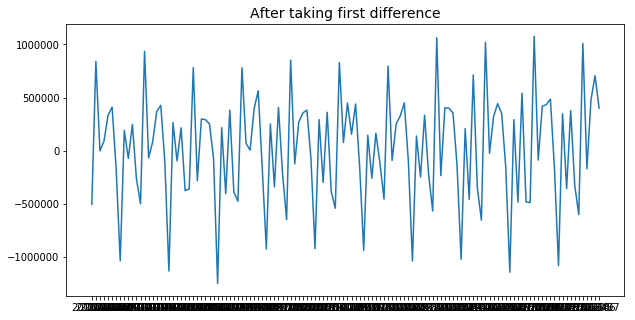

In [12]:
training_diff=training.diff().dropna()
plt.figure(figsize=(10,5))
plt.plot(training_diff)
plt.title("After taking first difference", fontsize=14)
plt.draw()

<a id="6"></a> <br>
## Model selection

We see here that there is no more trend. However, an unstable seasonal pattern is still present in this residual series. It indicates that we need to remove the seasonal pattern which can be done with SARIMA. We can select the seasonal pattern parameters of SARIMA by looking at the ACF and PACF plots.

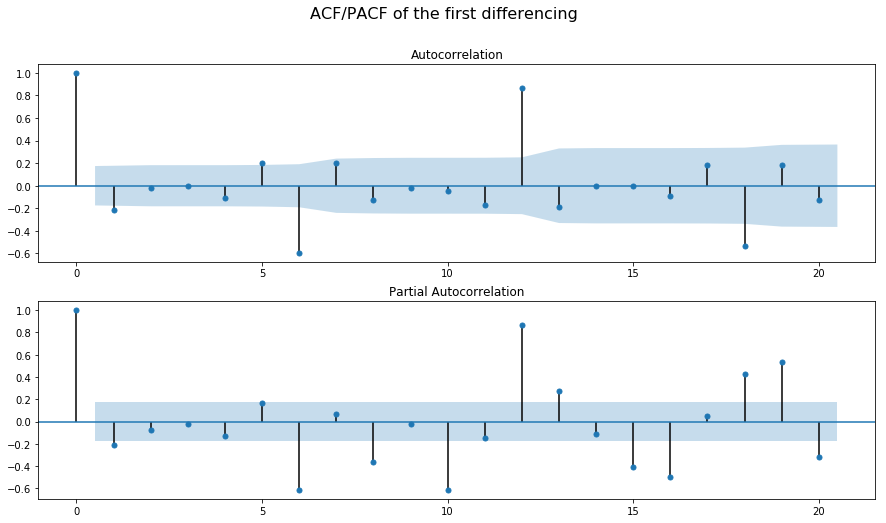

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(2,1,figsize=(15,8))
plt.suptitle("ACF/PACF of the first differencing", fontsize=16)
fig = sm.graphics.tsa.plot_acf(training_diff, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(training_diff, lags=20, ax=ax[1])
plt.show()

In [14]:
'''
Rules for SARIMA model selection from ACF/PACF plots
These are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA(p,d,q)(P,D,Q)[S]. It is an art in picking good parameters from the ACF/PACF plots. The following rules also apply to ARMA and ARIMA models.

Identifying the order of differencing:

d=0 if the series has no visible trend or ACF at all lags is low.

d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

Note: if after applying differencing to the series and the ACF at lag 1 is -0.5 or more negative the series may be overdifferenced.

Note: If you find the best d to be d=1 then the original series has a constant trend. A model with d=2 assumes that the original series has a time-varying trend.

Identifying the number of AR and MA terms
p is equal to the first lag where the PACF value is above the significance level.

q is equal to the first lag where the ACF value is above the significance level.

Identifying the seasonal part of the model:

S is equal to the ACF lag with the highest value (typically at a high lag).

D=1 if the series has a stable seasonal pattern over time.

D=0 if the series has an unstable seasonal pattern over time.

Rule of thumb: d+D≤2

P≥1 if the ACF is positive at lag S, else P=0.

Q≥1 if the ACF is negative at lag S, else Q=0.

Rule of thumb: P+Q≤2
'''

'\nRules for SARIMA model selection from ACF/PACF plots\nThese are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA(p,d,q)(P,D,Q)[S]. It is an art in picking good parameters from the ACF/PACF plots. The following rules also apply to ARMA and ARIMA models.\n\nIdentifying the order of differencing:\n\nd=0 if the series has no visible trend or ACF at all lags is low.\n\nd≥1 if the series has visible trend or positive ACF values out to a high number of lags.\n\nNote: if after applying differencing to the series and the ACF at lag 1 is -0.5 or more negative the series may be overdifferenced.\n\nNote: If you find the best d to be d=1 then the original series has a constant trend. A model with d=2 assumes that the original series has a time-varying trend.\n\nIdentifying the number of AR and MA terms\np is equal to the first lag where the PACF value is above the significance level.\n\nq is equal to the first lag where the ACF value is above the signi

Looking at the ACF and PACF plots of the differenced series we see our first most significant value at lag 6 for ACF and at the same lag 6 for the PACF which suggest to use p = 6 and q = 6. We also have a big value at lags 6,12,18,... in the ACF plot which suggests our season is S = 6. Since this is a differenced series for SARIMA we set d = 1, and since the seasonal pattern is not stable over time we set D = 0. All together this gives us a SARIMA(6,1,6)(1,0,0)[6] model. Next we run SARIMA with these values to fit a model on our training data.

<a id="7"></a> <br>
## Model fit and prediction

In [15]:
model_fit=SARIMAX(training, order=(6, 1, 6), seasonal_order=(1,0,0, 6), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE is:  155040.0


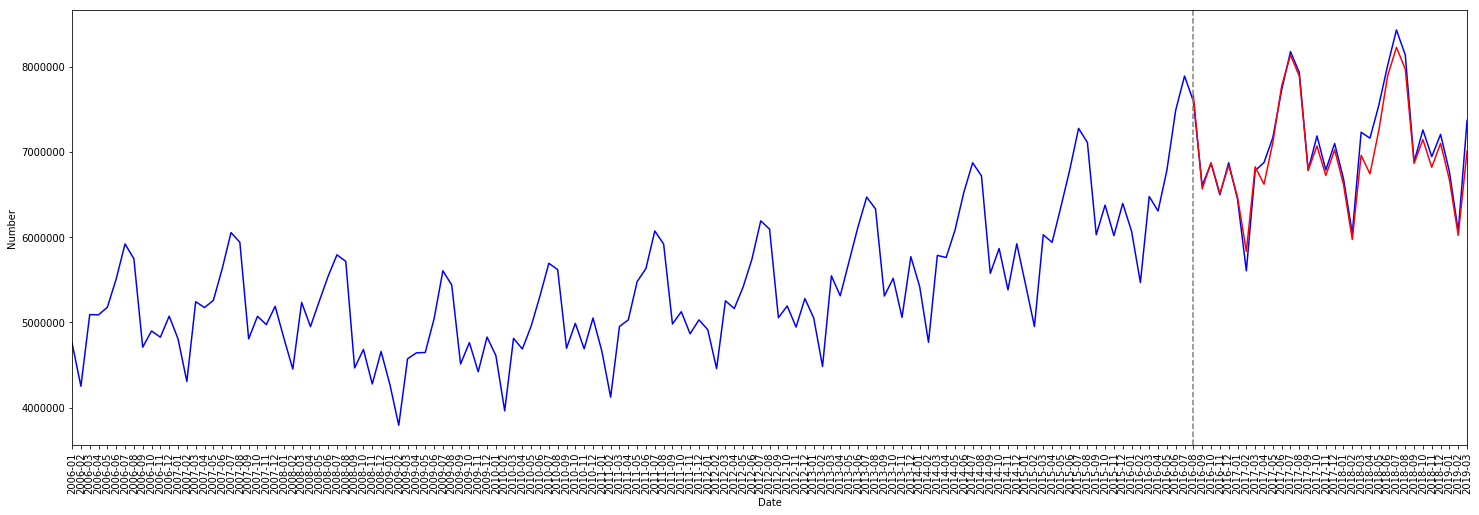

In [16]:
K=len(testing)
forecast=model_fit.forecast(K)
#forecast=np.exp(forecast)
forecast.index=testing.index
plt.figure(figsize=(25,8))
plt.plot(df,"b")
plt.plot(forecast, "r")
plt.xlabel("Date")
plt.ylabel("Number")
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x', tight=True)
plt.axvline(x=testing.index[0], linestyle='--', color="gray")
plt.draw()

from sklearn.metrics import mean_squared_error
print("RMSE is: ", round(np.sqrt(mean_squared_error(testing,forecast))))

<a id="8"></a> <br>
## Parameter tuning

Don't you agree that it's good enough from the first attempt.

However we can go on with tuning of parameters. Let's consider lags with higher values:

for p let's consider 1,6,8,10,12, for q the values 1,4,6,12, for P: 0,1,2, for Q: 0,1 and for S: 6 and 12.

With this many combinations, we still get a result very close to the one we got from our first attempt. Now RMSE is 154126 (so we have tiny improvement).

In [17]:
'''my_list=[]
for p in [6,8,10,12]:
    for q in [4,6,12]:
        for P in [0,1,2]:
            for Q in [0,1]:
                for S in [6, 12]:
                    for D in [0,1]:
                        for d in [1,2]:
                            model_fit=SARIMAX(training, order=(p,1,q), seasonal_order=(P,1,Q,S), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                            forecast=model_fit.forecast(32)
                            my_list.append(np.sqrt(mean_squared_error(testing,forecast)))
                            print(p,d,q,P,D,Q,S,np.sqrt(mean_squared_error(testing,forecast)))
print(np.min(my_list))'''


'my_list=[]\nfor p in [6,8,10,12]:\n    for q in [4,6,12]:\n        for P in [0,1,2]:\n            for Q in [0,1]:\n                for S in [6, 12]:\n                    for D in [0,1]:\n                        for d in [1,2]:\n                            model_fit=SARIMAX(training, order=(p,1,q), seasonal_order=(P,1,Q,S), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)\n                            forecast=model_fit.forecast(32)\n                            my_list.append(np.sqrt(mean_squared_error(testing,forecast)))\n                            print(p,d,q,P,D,Q,S,np.sqrt(mean_squared_error(testing,forecast)))\nprint(np.min(my_list))'

So, the model with the best result is the following:

In [18]:
model_fit=SARIMAX(training, order=(10, 1, 6), seasonal_order=(2, 1, 0, 6), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


New RMSE is:  154127.0


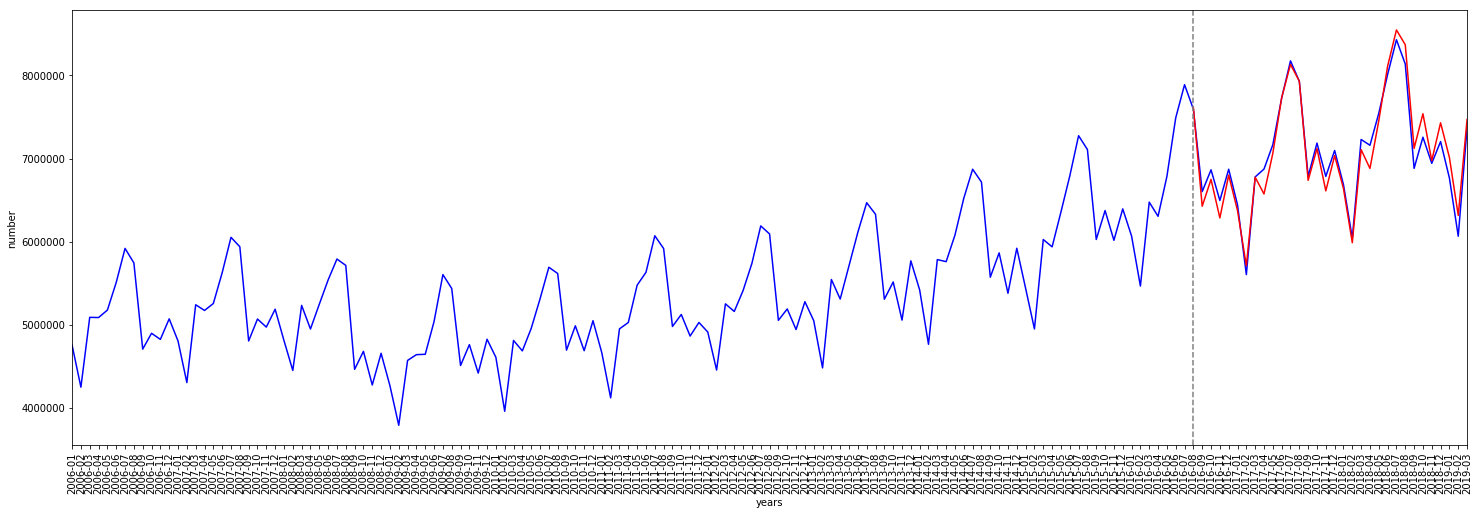

In [19]:
forecast=model_fit.forecast(K)
forecast.index=testing.index
plt.figure(figsize=(25,8))
plt.plot(df,"b")
plt.plot(forecast, "r")
plt.xlabel("years")
plt.ylabel("number")
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x', tight=True)
plt.axvline(x=testing.index[0], linestyle='--', color="gray")
plt.draw()
print("New RMSE is: ", round(np.sqrt(mean_squared_error(testing,forecast))))

<a id="9"></a> <br>
## Year ahead forecast

Now that we have a model built, we want to use it to make forecasts.



In [20]:
t=pd.date_range(start="2019-04", end="2020-04", freq="M")
future=pd.DataFrame(index=t, columns=file3.columns)
future.index=pd.to_datetime(future.index, format='%Y-%m-%d').strftime('%Y-%m')
df=pd.concat([file3, future], axis=0)

Now I will have use the predict function to create forecast values for these newlwy added time periods and plot them.

In [21]:
model_fit.predict(start=160, end=171)

2019-05-01    7.827190e+06
2019-06-01    8.504993e+06
2019-07-01    8.942420e+06
2019-08-01    8.785472e+06
2019-09-01    7.492708e+06
2019-10-01    7.951428e+06
2019-11-01    7.313445e+06
2019-12-01    7.763000e+06
2020-01-01    7.326165e+06
2020-02-01    6.604671e+06
2020-03-01    7.811382e+06
2020-04-01    7.493802e+06
Freq: MS, dtype: float64

In [22]:
df.Number.iloc[-12:]=model_fit.predict(start=160, end=171).values

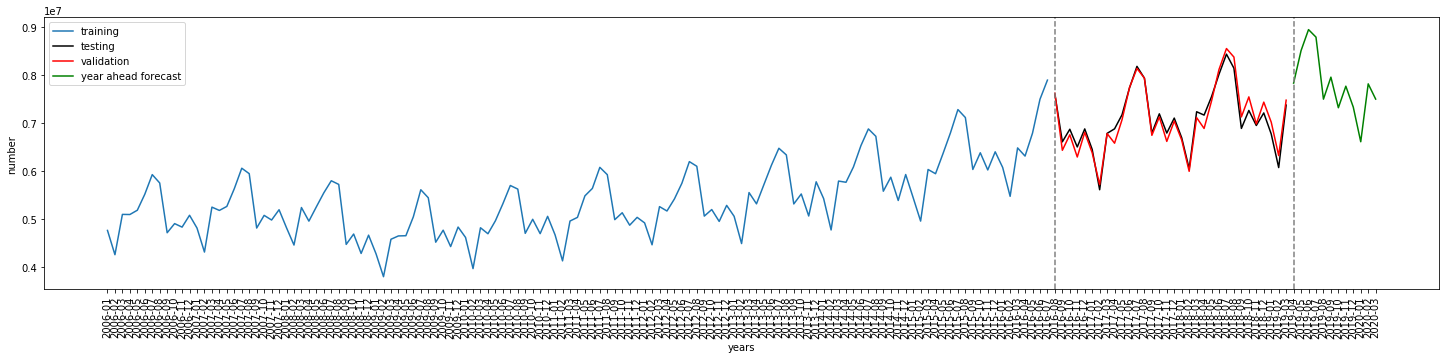

In [23]:
plt.figure(figsize=(25,5))
#b=df["Number"].iloc[-24:-12]
year_ahead_forecast=df["Number"].iloc[-12:]

plt.plot(training, label="training")
plt.plot(testing, "k", label="testing")
plt.plot(forecast, "r", label="validation")
plt.plot(year_ahead_forecast,"g", label="year ahead forecast")

plt.legend()
plt.axvline(x=testing.index[0], linestyle='--', color="gray")
plt.axvline(x=year_ahead_forecast.index[0], linestyle='--', color="gray")
plt.xlabel("years")
plt.ylabel("number")
plt.xticks(rotation=90)
plt.show()

<a id="10"></a> <br>
## Summary

Using data for LAX passengers we created a model (Seasonal ARIMA) to predict number of passengers one year ahead. We saw that the model fits the testing data prety well. It will be interesting to follow the real number of the passengers for upcoming months to see how well our model performs.

Hope you found this kernel interesting. If so, please UPVOTE!

In case of having some comments, you are always welcome...;)


